In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from typing import Optional, List
import matplotlib.pyplot as plt

In [2]:
num_batch, num_token, dim = 1, 10, 32
num_heads=2
window=2
x = torch.randn(num_batch,num_token,dim)
head_dim = dim // num_heads
kernel_size = 2*window + 1

# token 0 を global token にする例
global_mask = torch.zeros(num_batch,num_token, dtype=torch.bool)
global_mask[0,0] = True

In [3]:
# ネットワークパラメータ定義
q_proj = nn.Linear(dim, dim)
k_proj = nn.Linear(dim, dim)
v_proj = nn.Linear(dim, dim)
out_proj = nn.Linear(dim, dim)

In [4]:
# Q,K,Vの計算
q = q_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)
k = k_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)
v = v_proj(x).view(num_batch, num_token, num_heads, head_dim).transpose(1,2)

q.shape

torch.Size([1, 2, 10, 16])

local score


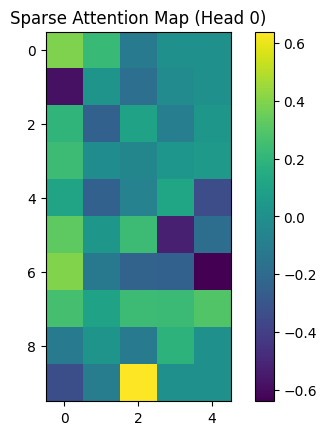

In [5]:
# Local scoreの計算
local_scores = torch.zeros(num_batch,num_heads,num_token,kernel_size, device=x.device)

for t in range(num_token):
  L = max(0, t-window)
  R = min(num_token, t+window+1)
  k_local = k[:,:,L:R,:]
  q_t = q[:,:,t:t+1,:]
  score = torch.einsum("bhid,bhjd->bhij", q_t, k_local) / (head_dim**0.5)
  local_scores[:,:,t,:R-L] = score.squeeze(2)

print("local score map")
# 可視化（head 0）
plt.imshow(local_scores[0,0].detach().cpu(), cmap="viridis")
plt.colorbar()
plt.title("Sparse Attention Map (Head 0)")
plt.show()


# 特別なトークン

Sparse Attention では "特別なトークン" にだけ Global Attention を行う

例えば：

[CLS] トークン

質問応答の "質問側" トークン

セパレータトークン

重要な文に手動で指定された token

前提

q: (B, H, T, D)

k: (B, H, T, D)

global_mask[b]: (T,): True の位置がグローバルトークン位置

計算後の形
変数	形状	意味
idx	(G,)	global トークン数
k_g	(H, G, D)	global key
score	(H, T, G)	各 Query から Global Key への attention score

In [13]:
global_mask

tensor([[ True, False, False, False, False, False, False, False, False, False]])

global_maskの先頭がTrueなのは上記の通り先頭→先頭がグローバルトークン

In [6]:
# --------------------------------------------------------------
# Global scores
# --------------------------------------------------------------
global_scores = []
global_idx_list = []

for b in range(num_batch):
    idx = torch.nonzero(global_mask[b], as_tuple=False).squeeze(-1)
    global_idx_list.append(idx)
    if idx.numel() == 0:
        global_scores.append(None)
        continue
    k_g = k[b,:,idx,:]
    score = torch.einsum("htd,hgd->htg", q[b], k_g) / (head_dim**0.5)
    global_scores.append(score)



In [ ]:
num_batch, num_token, dim = 1, 10, 32
num_heads=2
window=2
x = torch.randn(num_batch,num_token,dim)
head_dim = dim // num_heads
kernel_size = 2*window + 1

local score map


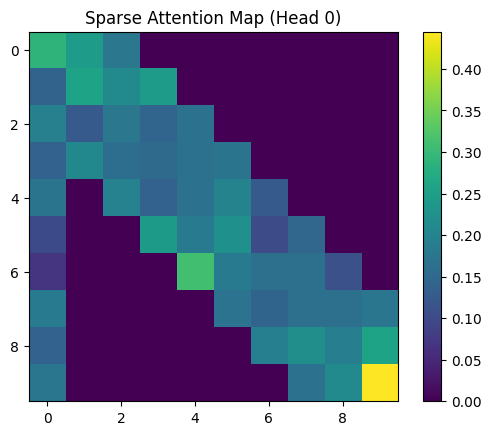

In [19]:
# --------------------------------------------------------------
# Out: heads
# --------------------------------------------------------------
out_heads = torch.zeros(num_batch,num_heads,num_token,head_dim, device=x.device)
full_attn = torch.zeros(num_batch,num_heads,num_token,num_token, device=x.device)

for b in range(num_batch):
    for h in range(num_heads):
        for t in range(num_token):

            L = max(0, t-window)
            R = min(num_token, t+window+1)
            local_s = local_scores[b,h,t,:R-L]

            if global_scores[b] is None:
                attn = F.softmax(local_s, dim=-1)
                v_loc = v[b,h,L:R,:]
                ctx = torch.sum(attn.unsqueeze(-1)*v_loc, dim=-2)

                # full attention map
                full_attn[b,h,t,L:R] = attn

            else:
                g_idx = global_idx_list[b]
                g_score = global_scores[b][h,t]   # (G)
                s = torch.cat([local_s, g_score], dim=-1)
                attn = F.softmax(s, dim=-1)

                # separate weights
                attn_loc = attn[:R-L]
                attn_g   = attn[R-L:]

                v_loc = v[b,h,L:R,:]
                v_g   = v[b,h,g_idx,:]

                ctx = (
                    torch.sum(attn_loc.unsqueeze(-1)*v_loc, dim=-2) +
                    torch.sum(attn_g.unsqueeze(-1)*v_g, dim=-2)
                )

                out_heads[b,h,t] = ctx

                # ★ full attention map の構築
                full_attn[b,h,t,L:R] = attn_loc
                full_attn[b,h,t, g_idx] = attn_g


print("local score map")
# 可視化（head 0）
plt.imshow(full_attn[0,0].detach().cpu(), cmap="viridis")
plt.colorbar()
plt.title("Sparse Attention Map (Head 0)")
plt.show()